✅ STAGE-1 — CROSS-DATASET INTEGRATION

Objective:
Combine enrolment and demographic update datasets into a single governance-ready analytical table without altering original datasets.

📘 Notebook Structure

1. Introduction
2. Dataset Description
3. Data Cleaning & Preprocessing
4. Feature Engineering
5. EDA
6. Advanced Indicators (dataset-wise)


7. STAGE-1: Cross-Dataset Integration   ✅  ← PUT THIS CODE HERE


8. Cross-Dataset Analytics
9. Decision Matrix
10. Storytelling Visuals


In [16]:
# ============================================================
# STAGE–1 : CROSS–DATASET INTEGRATION
# ============================================================
# Purpose:
#   • Combine Aadhaar Enrolment & Demographic Update datasets
#   • Align temporal + geographic dimensions
#   • Preserve dataset independence
#   • Create governance-ready analytical base
#
# IMPORTANT:
#   - No recalculation of previous metrics
#   - No overwriting of source indicators
#   - Integration happens only at analytical layer
#
# Output:
#   master_state_month.csv
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. LOAD CLEAN AGGREGATED DATASETS
# ------------------------------------------------------------

enrolment = pd.read_csv("state_month_enrolment.csv")
demographic = pd.read_csv("state_month_demographic.csv")

print("Enrolment rows :", enrolment.shape)
print("Demographic rows:", demographic.shape)

# ------------------------------------------------------------
# 2. BASIC VALIDATION
# ------------------------------------------------------------

required_keys = ["state_clean", "year", "month"]

assert all(col in enrolment.columns for col in required_keys)
assert all(col in demographic.columns for col in required_keys)

# Ensure correct datatypes
for col in ["year", "month"]:
    enrolment[col] = enrolment[col].astype(int)
    demographic[col] = demographic[col].astype(int)

# ------------------------------------------------------------
# 3. INNER JOIN — GOVERNANCE INTERSECTION
# ------------------------------------------------------------
# Why INNER JOIN?
#
# • Prevents artificial inflation
# • Ensures both enrolment and update activity exist
# • Matches UIDAI monthly reporting structure
#
# ------------------------------------------------------------

master = pd.merge(
    enrolment,
    demographic,
    on=["state_clean", "year", "month"],
    how="inner",
    suffixes=("_enrol", "_demo")
)

print("Merged rows:", master.shape)

# ------------------------------------------------------------
# 4. COLUMN STANDARDISATION
# ------------------------------------------------------------
# Prevent naming ambiguity for policy interpretation

rename_map = {
    "volatility": "enrolment_volatility",
    "update_volatility": "demographic_update_volatility",
    "lifecycle_transition_score": "enrolment_lifecycle_index",
    "demographic_lifecycle_index": "update_lifecycle_index"
}

master.rename(columns=rename_map, inplace=True)

# ------------------------------------------------------------
# 5. DERIVED CROSS–DATASET METRICS
# ------------------------------------------------------------

# ------------------------------------------------------------
# 5.1 Total lifecycle load
# ------------------------------------------------------------
master["total_identity_activity"] = (
    master["total_enrolment"] +
    master["total_demo_updates"]
)

# ------------------------------------------------------------
# 5.2 Update-to-Enrolment Ratio
# ------------------------------------------------------------
# Core governance pressure metric

master["update_to_enrolment_ratio"] = (
    master["total_demo_updates"] /
    master["total_enrolment"].replace(0, np.nan)
)

# ------------------------------------------------------------
# 5.3 Lifecycle Dominance Index
# ------------------------------------------------------------
# Positive → update driven governance
# Negative → enrolment expansion

master["lifecycle_dominance_index"] = (
    master["total_demo_updates"] -
    master["total_enrolment"]
)

# ------------------------------------------------------------
# 6. GOVERNANCE PHASE CLASSIFICATION
# ------------------------------------------------------------

def governance_phase(row):

    if (
        row["saturation_index"] >= 0.8 and
        row["update_saturation_index"] >= 0.7
    ):
        return "Fully Saturated – Maintenance Phase"

    elif (
        row["saturation_index"] >= 0.7 and
        row["update_saturation_index"] < 0.4
    ):
        return "Coverage Complete – Update Gap"

    elif row["saturation_index"] < 0.4:
        return "Coverage Expansion Phase"

    else:
        return "Lifecycle Transition Phase"


master["governance_phase"] = master.apply(governance_phase, axis=1)

# ------------------------------------------------------------
# 7. FINAL COLUMN ORDER (READABILITY)
# ------------------------------------------------------------

core_cols = [
    "state_clean", "year", "month",
    "total_enrolment", "total_demo_updates",
    "total_identity_activity",
    "update_to_enrolment_ratio",
    "lifecycle_dominance_index",
    "governance_phase"
]

remaining_cols = [c for c in master.columns if c not in core_cols]

master = master[core_cols + remaining_cols]

# ------------------------------------------------------------
# 8. EXPORT MASTER GOVERNANCE TABLE
# ------------------------------------------------------------

master.to_csv("state_month_master_governance.csv", index=False)

print("--------------------------------------------------")
print(" MASTER GOVERNANCE DATASET CREATED ✅")
print(" Rows    :", master.shape[0])
print(" Columns :", master.shape[1])
print(" Saved as: state_month_master_governance.csv")
print("--------------------------------------------------")

master.head()


Enrolment rows : (266, 18)
Demographic rows: (269, 23)
Merged rows: (238, 38)
--------------------------------------------------
 MASTER GOVERNANCE DATASET CREATED ✅
 Rows    : 238
 Columns : 42
 Saved as: state_month_master_governance.csv
--------------------------------------------------


,state_clean,year,month,total_enrolment,total_demo_updates,total_identity_activity,update_to_enrolment_ratio,lifecycle_dominance_index,governance_phase,age_0_5,...,update_lifecycle_index,governance_load_index,age_shift_momentum_demo,update_zscore,is_anomaly,norm_saturation,norm_lifecycle,norm_volatility,governance_risk_score,policy_action
0,Andaman And Nicobar Islands,2025,9,145,618,763,4.262069,473,Lifecycle Transition Phase,133,...,0.818770,0.410125,506,-0.312692,False,0.473340,0.756713,0.000321,1.283694,Routine Monitoring
1,Andaman And Nicobar Islands,2025,10,60,453,513,7.550000,393,Lifecycle Transition Phase,52,...,0.743929,0.319528,337,-0.739091,False,0.345922,0.612393,0.000267,1.266738,Routine Monitoring
2,Andaman And Nicobar Islands,2025,11,88,913,1001,10.375000,825,Lifecycle Transition Phase,85,...,0.772180,0.456096,705,0.449657,False,0.701147,0.666870,0.000272,0.965995,Routine Monitoring
3,Andaman And Nicobar Islands,2025,12,97,1300,1397,13.402062,1203,Lifecycle Transition Phase,93,...,0.816923,0.584500,1062,1.449755,False,1.000000,0.753151,0.000349,0.753500,Stable
4,Andhra Pradesh,2025,3,116,370695,370811,3195.646552,370579,Fully Saturated – Maintenance Phase,43,...,0.811640,NaN,300871,1.506496,False,1.000000,0.742964,NaN,NaN,Stable


✅ STAGE-2 : ADVANCED GOVERNANCE ANALYTICS CODE

🔹 1️⃣ Load Master Governance Dataset

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# Load master dataset
df = pd.read_csv("state_month_master_governance.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (238, 42)


,state_clean,year,month,total_enrolment,total_demo_updates,total_identity_activity,update_to_enrolment_ratio,lifecycle_dominance_index,governance_phase,age_0_5,...,update_lifecycle_index,governance_load_index,age_shift_momentum_demo,update_zscore,is_anomaly,norm_saturation,norm_lifecycle,norm_volatility,governance_risk_score,policy_action
0,Andaman And Nicobar Islands,2025,9,145,618,763,4.262069,473,Lifecycle Transition Phase,133,...,0.818770,0.410125,506,-0.312692,False,0.473340,0.756713,0.000321,1.283694,Routine Monitoring
1,Andaman And Nicobar Islands,2025,10,60,453,513,7.550000,393,Lifecycle Transition Phase,52,...,0.743929,0.319528,337,-0.739091,False,0.345922,0.612393,0.000267,1.266738,Routine Monitoring
2,Andaman And Nicobar Islands,2025,11,88,913,1001,10.375000,825,Lifecycle Transition Phase,85,...,0.772180,0.456096,705,0.449657,False,0.701147,0.666870,0.000272,0.965995,Routine Monitoring
3,Andaman And Nicobar Islands,2025,12,97,1300,1397,13.402062,1203,Lifecycle Transition Phase,93,...,0.816923,0.584500,1062,1.449755,False,1.000000,0.753151,0.000349,0.753500,Stable
4,Andhra Pradesh,2025,3,116,370695,370811,3195.646552,370579,Fully Saturated – Maintenance Phase,43,...,0.811640,NaN,300871,1.506496,False,1.000000,0.742964,NaN,NaN,Stable


🔹 2️⃣ Governance Quadrant Classification

| Enrol Saturation | Update Saturation | Governance Zone           |
| ---------------- | ----------------- | ------------------------- |
| Low              | Low               | Expansion Phase           |
| High             | Low               | Update Infrastructure Gap |
| Low              | High              | Transition Risk           |
| High             | High              | Maintenance Mode          |


In [18]:
# Thresholds (median-based for robustness)
enrol_thresh = df["saturation_index"].median()
update_thresh = df["update_saturation_index"].median()

def governance_quadrant(row):
    if row["saturation_index"] < enrol_thresh and row["update_saturation_index"] < update_thresh:
        return "Expansion Phase"
    elif row["saturation_index"] >= enrol_thresh and row["update_saturation_index"] < update_thresh:
        return "Update Infra Gap"
    elif row["saturation_index"] < enrol_thresh and row["update_saturation_index"] >= update_thresh:
        return "Transition Risk"
    else:
        return "Maintenance Mode"

df["governance_quadrant"] = df.apply(governance_quadrant, axis=1)

df["governance_quadrant"].value_counts()


governance_quadrant
Update Infra Gap    68
Transition Risk     68
Maintenance Mode    53
Expansion Phase     49
Name: count, dtype: int64

Enrolment vs Demographic Update Volume

📌 Interpretation

Above diagonal → update-dominant states

Below diagonal → enrolment-dominant states

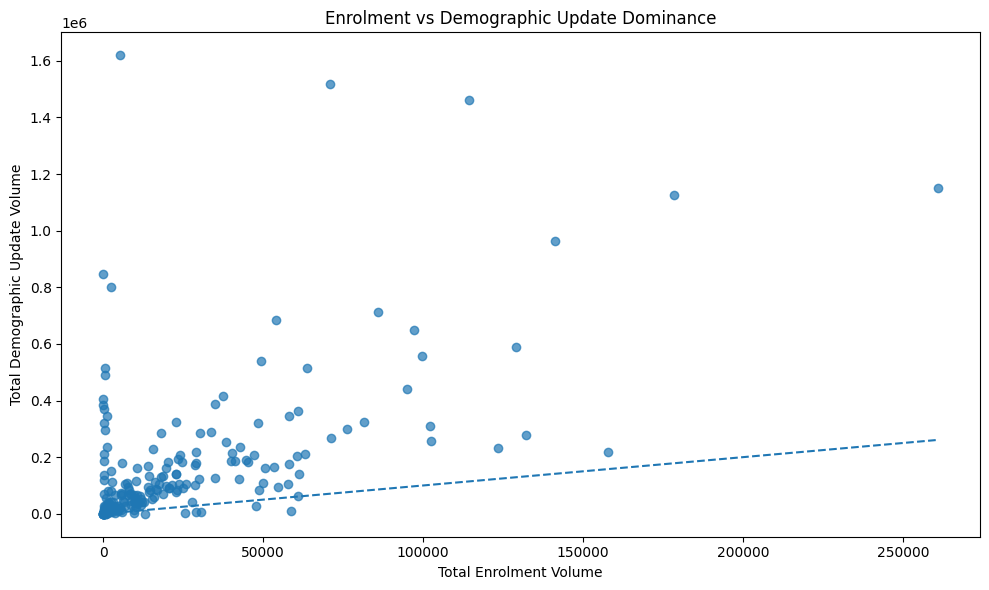

In [19]:
# Enrolment vs Demographic Update Volume
plt.figure(figsize=(10,6))

plt.scatter(
    df["total_enrolment"],
    df["total_demo_updates"],
    alpha=0.7
)

plt.plot(
    [0, df["total_enrolment"].max()],
    [0, df["total_enrolment"].max()],
    linestyle="--"
)

plt.xlabel("Total Enrolment Volume")
plt.ylabel("Total Demographic Update Volume")
plt.title("Enrolment vs Demographic Update Dominance")

plt.tight_layout()
plt.show()


Update-to-Enrolment Ratio Trend

📌 Shows structural shift from enrolment → maintenance.

In [25]:
# --------------------------------------------
# Create proper datetime column
# --------------------------------------------

df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" +
    df["month"].astype(str) + "-01"
)

df = df.sort_values("date")

df[["year", "month", "date"]].head()


,year,month,date
129,2025,3,2025-03-01
229,2025,3,2025-03-01
72,2025,3,2025-03-01
211,2025,3,2025-03-01
15,2025,3,2025-03-01


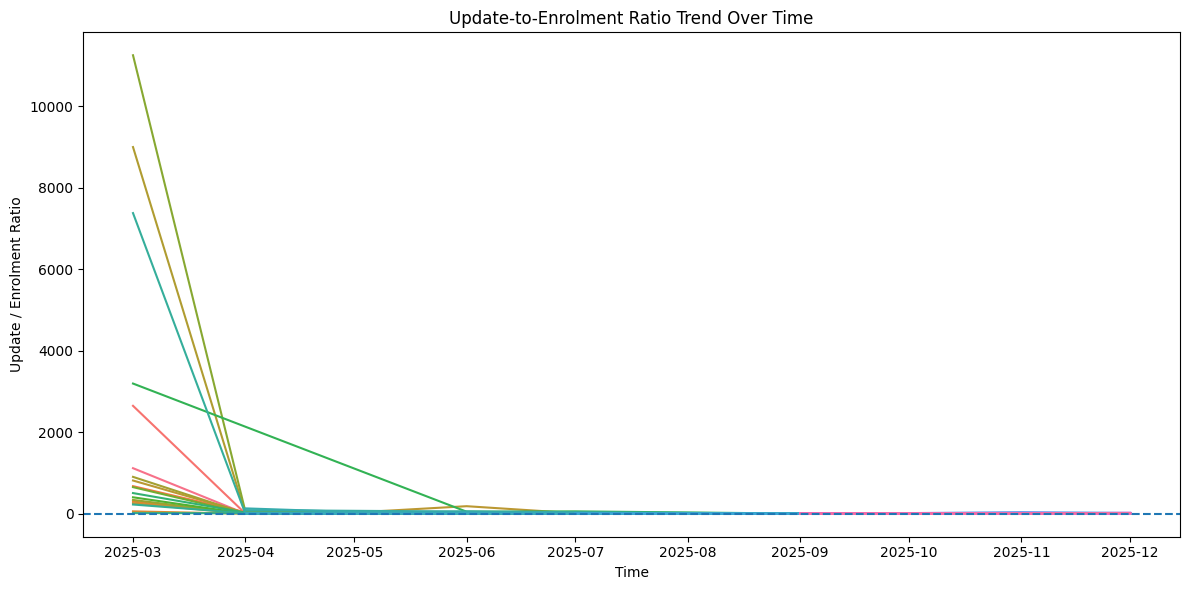

In [26]:
plt.figure(figsize=(12,6))

sns.lineplot(
    data=df,
    x="date",
    y="update_to_enrolment_ratio",
    hue="state_clean",
    legend=False
)

plt.axhline(1, linestyle="--")

plt.title("Update-to-Enrolment Ratio Trend Over Time")
plt.ylabel("Update / Enrolment Ratio")
plt.xlabel("Time")

plt.tight_layout()
plt.show()


Lifecycle Dominance Scatter


📌

Left → update dominated

Right → enrolment dominated



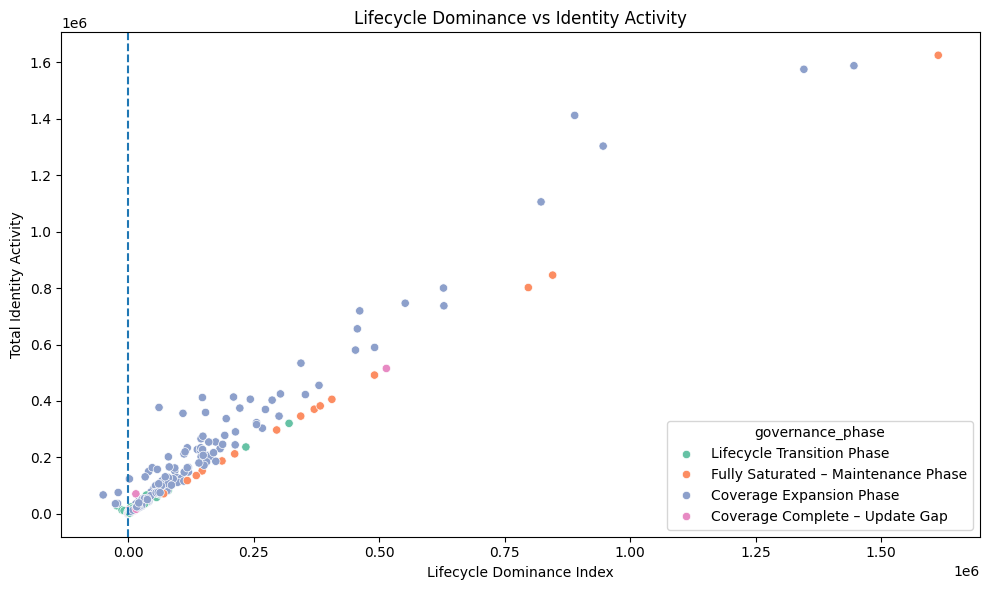

In [22]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df,
    x="lifecycle_dominance_index",
    y="total_identity_activity",
    hue="governance_phase",
    palette="Set2"
)

plt.axvline(0, linestyle="--")

plt.xlabel("Lifecycle Dominance Index")
plt.ylabel("Total Identity Activity")
plt.title("Lifecycle Dominance vs Identity Activity")

plt.tight_layout()
plt.show()


Governance Quadrant Map

📌 Identifies:

Stable mature states

High-risk saturated states

Growing expansion states

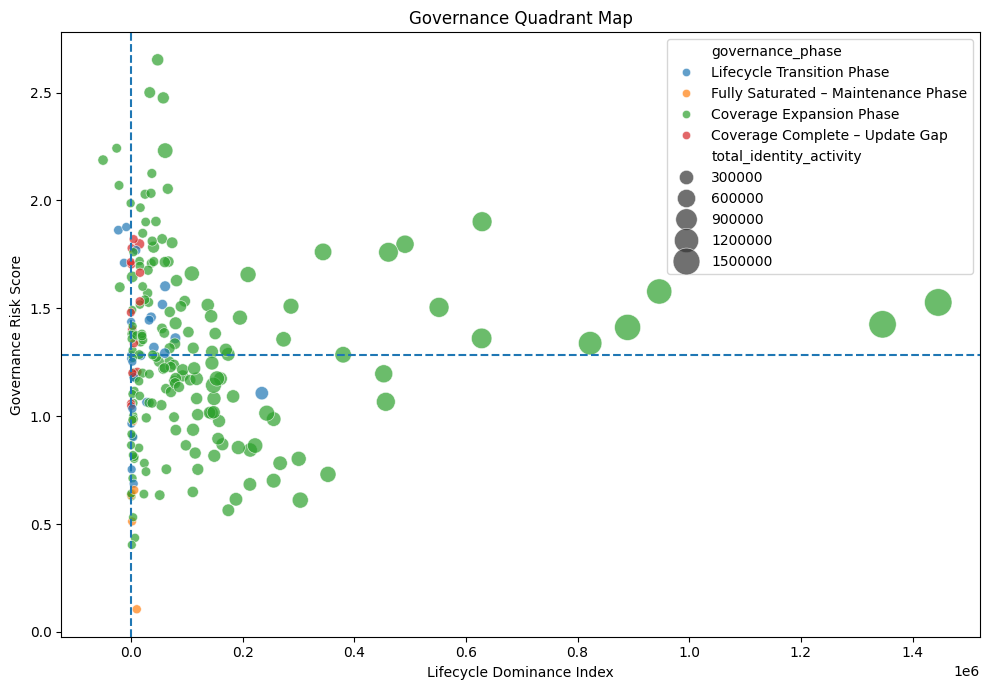

In [23]:
plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df,
    x="lifecycle_dominance_index",
    y="governance_risk_score",
    hue="governance_phase",
    size="total_identity_activity",
    sizes=(40, 400),
    alpha=0.7
)

plt.axhline(df["governance_risk_score"].mean(), linestyle="--")
plt.axvline(0, linestyle="--")

plt.xlabel("Lifecycle Dominance Index")
plt.ylabel("Governance Risk Score")
plt.title("Governance Quadrant Map")

plt.tight_layout()
plt.show()


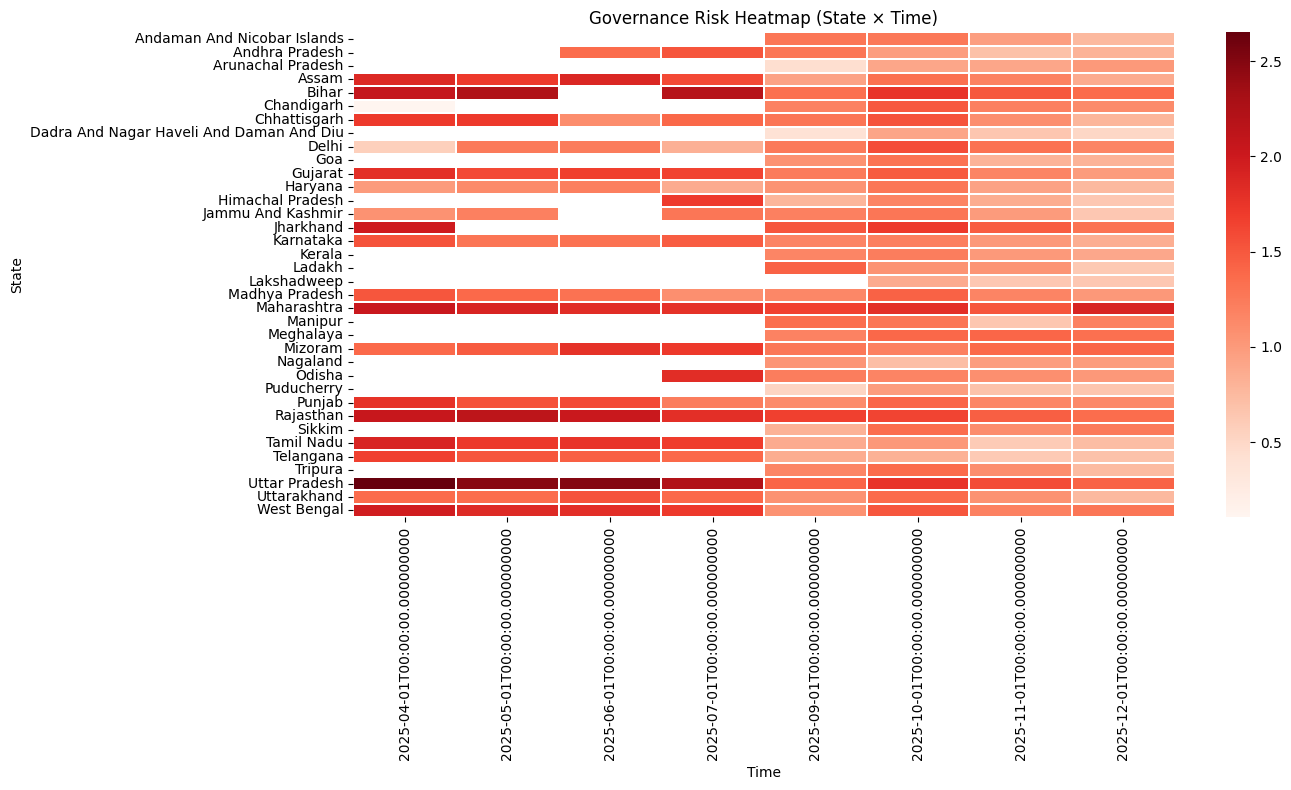

In [28]:
risk_pivot = df.pivot_table(
    index="state_clean",
    columns="date",
    values="governance_risk_score",
    aggfunc="mean"
)

plt.figure(figsize=(14,8))

sns.heatmap(
    risk_pivot,
    cmap="Reds",
    linewidths=0.2
)

plt.title("Governance Risk Heatmap (State × Time)")
plt.xlabel("Time")
plt.ylabel("State")

plt.tight_layout()
plt.show()


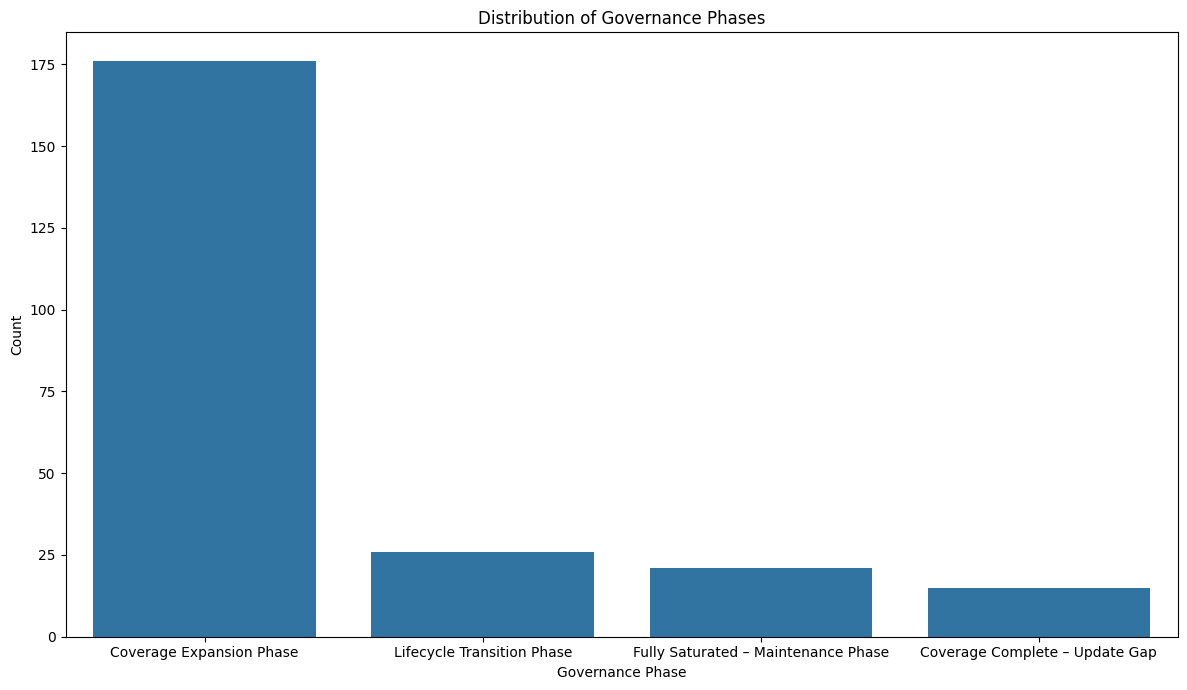

In [33]:
plt.figure(figsize=(12,7))

sns.countplot(
    data=df,
    x="governance_phase",
    order=df["governance_phase"].value_counts().index
)

plt.title("Distribution of Governance Phases")
plt.xlabel("Governance Phase")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


Policy Action Map

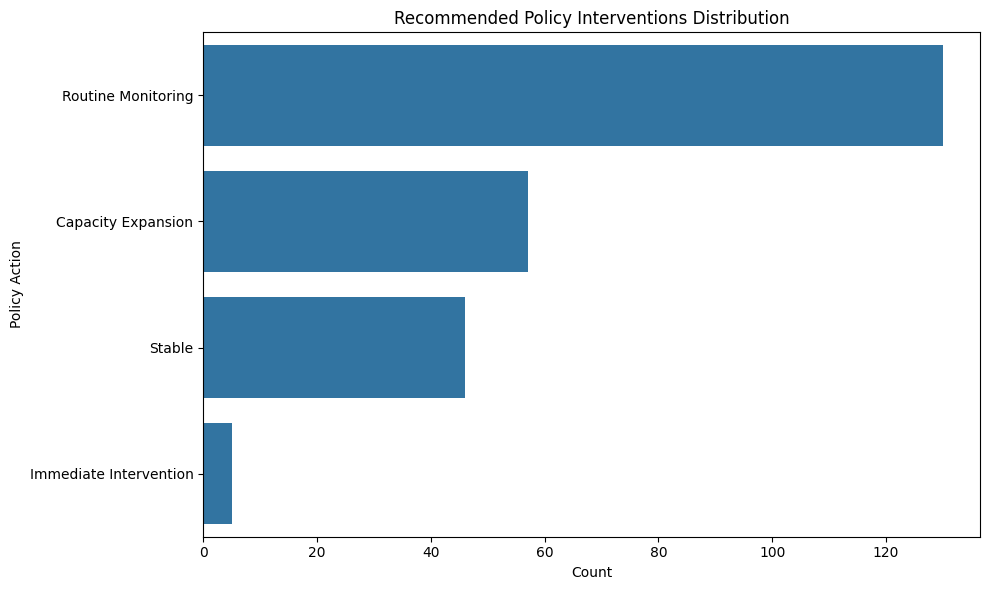

In [34]:
plt.figure(figsize=(10,6))

sns.countplot(
    data=df,
    y="policy_action",
    order=df["policy_action"].value_counts().index
)

plt.title("Recommended Policy Interventions Distribution")
plt.xlabel("Count")
plt.ylabel("Policy Action")

plt.tight_layout()
plt.show()


🔹 3️⃣ Governance Quadrant Scatter Plot (KEY VISUAL)

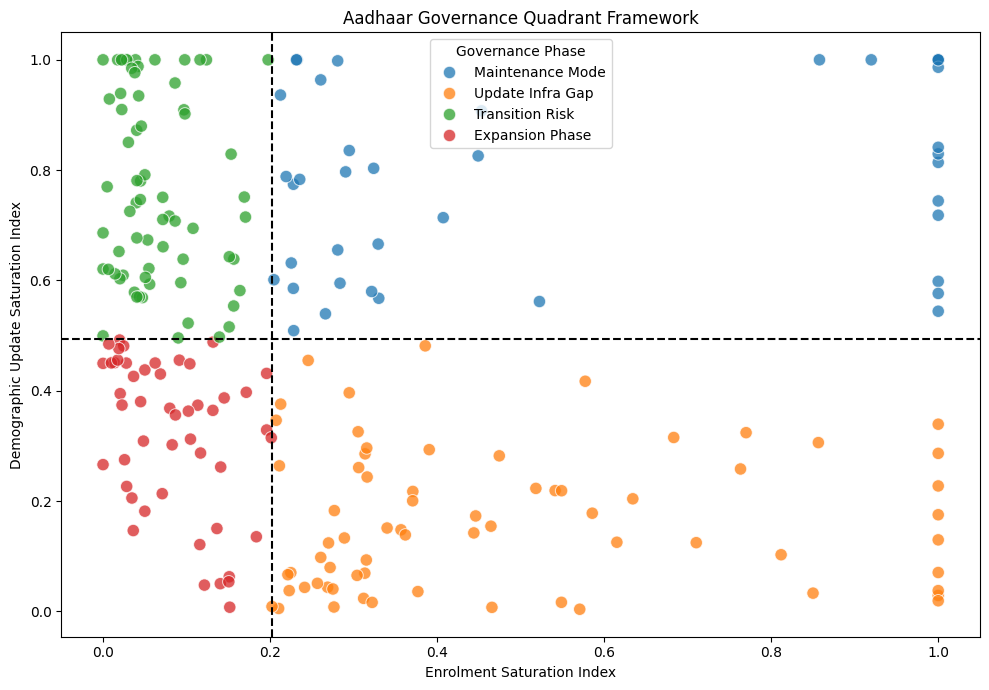

In [5]:
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df,
    x="saturation_index",
    y="update_saturation_index",
    hue="governance_quadrant",
    alpha=0.75,
    s=80
)

plt.axvline(enrol_thresh, linestyle="--", color="black")
plt.axhline(update_thresh, linestyle="--", color="black")

plt.title("Aadhaar Governance Quadrant Framework")
plt.xlabel("Enrolment Saturation Index")
plt.ylabel("Demographic Update Saturation Index")

plt.legend(title="Governance Phase")
plt.tight_layout()
plt.show()


🔹 4️⃣ Identity Lifecycle Dominance Analysis

Measures whether enrolment or updates dominate.

| Value   | Meaning             |
| ------- | ------------------- |
| < 0.5   | Enrolment dominated |
| 0.5–1.0 | Balanced            |
| > 1.0   | Update dominated    |


In [6]:
df["lifecycle_dominance_index"] = (
    df["total_demo_updates"] / df["total_enrolment"]
).replace([np.inf, -np.inf], np.nan)

df[["state_clean", "year", "month", "lifecycle_dominance_index"]].head()


,state_clean,year,month,lifecycle_dominance_index
0,Andaman And Nicobar Islands,2025,9,4.262069
1,Andaman And Nicobar Islands,2025,10,7.550000
2,Andaman And Nicobar Islands,2025,11,10.375000
3,Andaman And Nicobar Islands,2025,12,13.402062
4,Andhra Pradesh,2025,3,3195.646552


🔹 5️⃣ National Governance Risk Ranking

In [7]:
risk_rank = (
    df.groupby("state_clean")["governance_risk_score"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

risk_rank.head(10)


,state_clean,governance_risk_score
0,Uttar Pradesh,2.004191
1,Maharashtra,1.802343
2,Bihar,1.780501
3,Rajasthan,1.764900
4,Jharkhand,1.597964
5,West Bengal,1.549777
6,Mizoram,1.453055
7,Gujarat,1.451636
8,Assam,1.422180
9,Punjab,1.367679


🔥 Visual — Top 10 High-Risk States

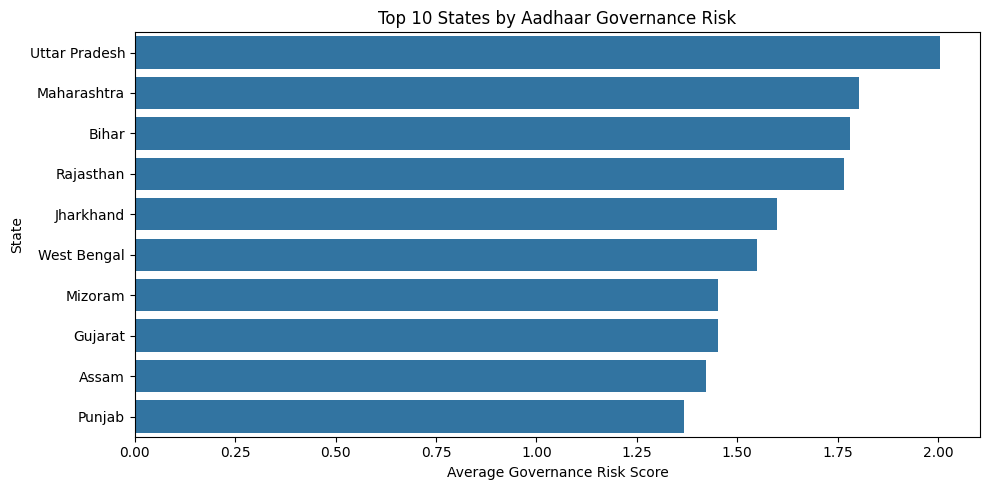

In [8]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=risk_rank.head(10),
    x="governance_risk_score",
    y="state_clean"
)

plt.title("Top 10 States by Aadhaar Governance Risk")
plt.xlabel("Average Governance Risk Score")
plt.ylabel("State")
plt.tight_layout()
plt.show()


🔹 6️⃣ Policy Action Distribution

In [9]:
policy_dist = df["policy_action"].value_counts()

policy_dist


policy_action
Routine Monitoring        130
Capacity Expansion         57
Stable                     46
Immediate Intervention      5
Name: count, dtype: int64

Visual

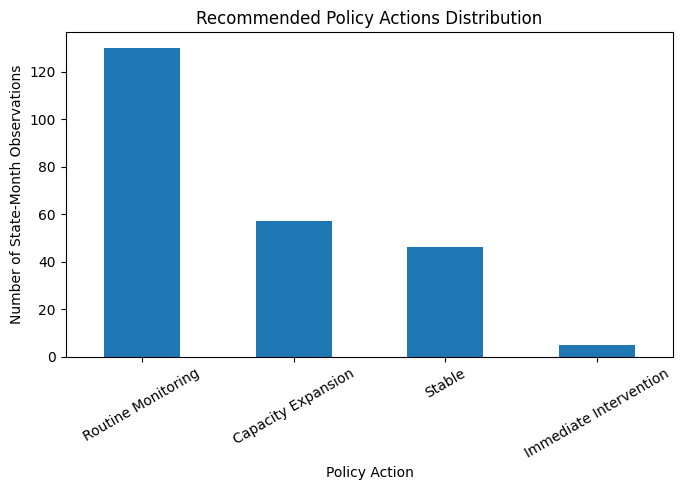

In [10]:
plt.figure(figsize=(7, 5))

policy_dist.plot(kind="bar")

plt.title("Recommended Policy Actions Distribution")
plt.xlabel("Policy Action")
plt.ylabel("Number of State-Month Observations")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


🔹 7️⃣ Anomaly Monitoring Dashboard

In [11]:
anomaly_df = df[df["is_anomaly"] == 1]

print("Total anomaly records:", anomaly_df.shape[0])

anomaly_df[[
    "state_clean",
    "year",
    "month",
    "update_zscore",
    "total_demo_updates"
]].head()


Total anomaly records: 0


,state_clean,year,month,update_zscore,total_demo_updates


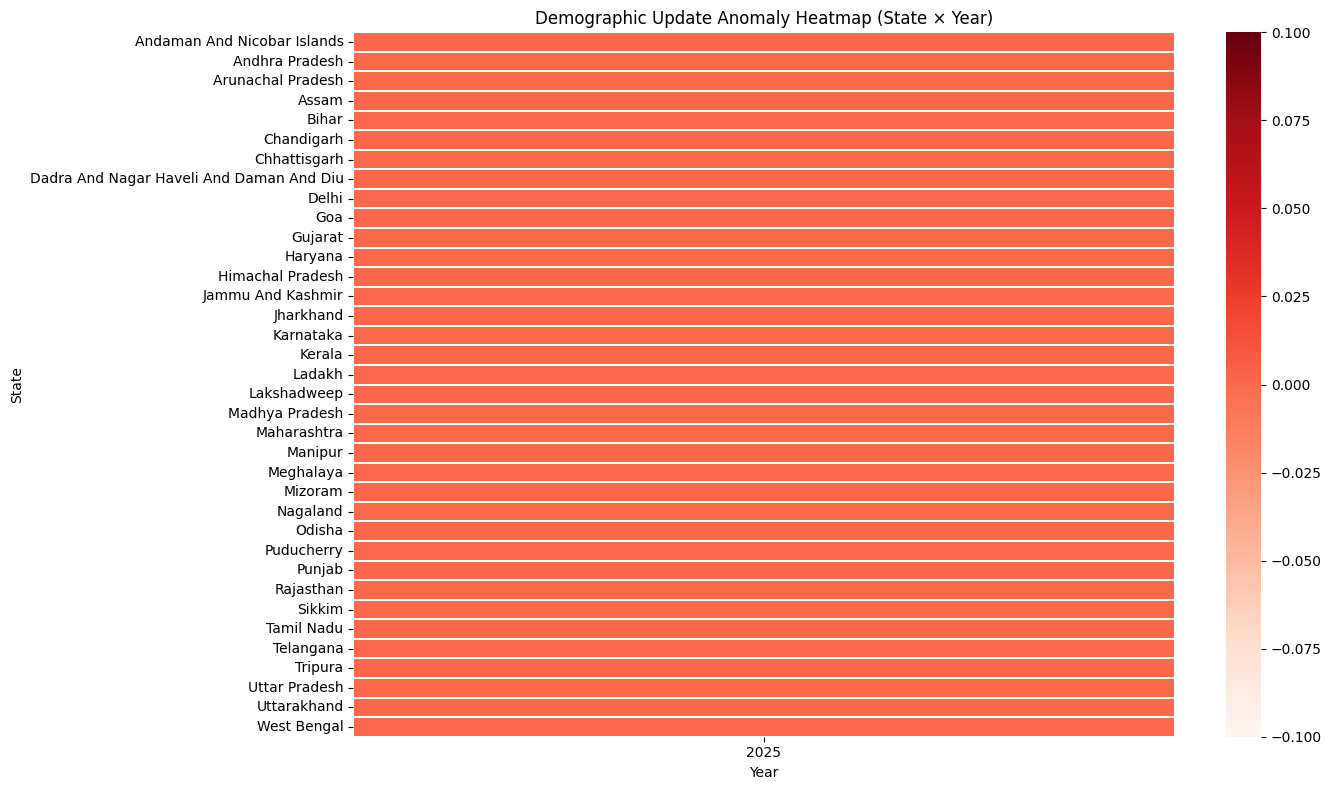

In [12]:
# Anomaly Heatmap
pivot_anomaly = (
    df.pivot_table(
        index="state_clean",
        columns="year",
        values="is_anomaly",
        aggfunc="sum"
    )
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_anomaly, cmap="Reds", linewidths=0.3)

plt.title("Demographic Update Anomaly Heatmap (State × Year)")
plt.xlabel("Year")
plt.ylabel("State")
plt.tight_layout()
plt.show()


🔹 8️⃣ Lifecycle Transition Map

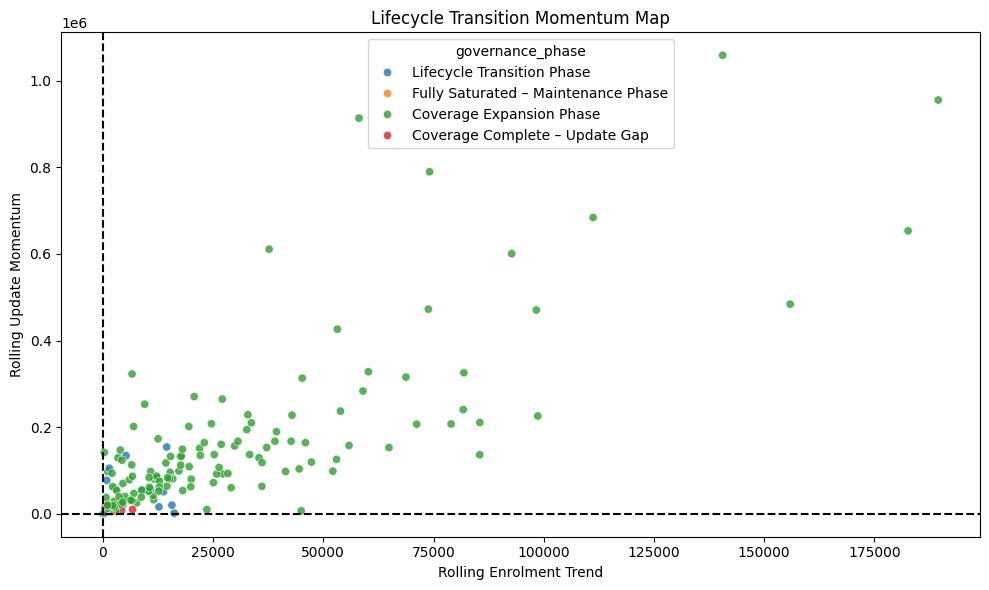

In [13]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="rolling_enrolment_trend",
    y="rolling_update_momentum",
    hue="governance_phase",
    alpha=0.8
)

plt.axhline(0, linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

plt.title("Lifecycle Transition Momentum Map")
plt.xlabel("Rolling Enrolment Trend")
plt.ylabel("Rolling Update Momentum")
plt.tight_layout()
plt.show()


🔹 9️⃣ Final Storytelling Summary Table

In [14]:
story_table = df.groupby("state_clean").agg({
    "total_enrolment": "mean",
    "total_demo_updates": "mean",
    "update_to_enrolment_ratio": "mean",
    "governance_risk_score": "mean",
    "policy_action": lambda x: x.value_counts().idxmax()
}).reset_index()

story_table.head()


,state_clean,total_enrolment,total_demo_updates,update_to_enrolment_ratio,governance_risk_score,policy_action
0,Andaman And Nicobar Islands,97.500000,821.000000,8.897283,1.067482,Routine Monitoring
1,Andhra Pradesh,17753.285714,216944.000000,477.503313,1.107906,Routine Monitoring
2,Arunachal Pradesh,939.000000,5556.500000,7.033187,0.812373,Routine Monitoring
3,Assam,25039.888889,83899.666667,9.047530,1.422180,Capacity Expansion
4,Bihar,67543.125000,448351.125000,45.864097,1.780501,Capacity Expansion


🔹 10️⃣ Export Final Analytics Outputs

In [15]:
df.to_csv("final_master_governance_dataset.csv", index=False)
risk_rank.to_csv("state_governance_risk_ranking.csv", index=False)
story_table.to_csv("state_policy_summary.csv", index=False)

print("✅ Stage-2 Outputs Saved Successfully")


✅ Stage-2 Outputs Saved Successfully
